### 1. Výpočet tepové frekvence z EKG signálu

In [19]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# https://physionet.org/content/butqdb/1.0.0/
ecg_100001 = wfdb.rdrecord("100001_ECG")

In [21]:
signal_info = [
    ["Název souboru", ecg_100001.record_name],
    ["Vzorkovací frekvence", ecg_100001.fs],
    ["Délka signálu (vzorky)", ecg_100001.sig_len],
    ["Počet kanálů", ecg_100001.n_sig],
    ["Názvy kanálů", ", ".join(ecg_100001.sig_name)],
    ["Jednotky pro každý kanál", ", ".join(ecg_100001.units)],
]

pd.DataFrame(signal_info, columns=["Informace", "Hodnota"])

,Informace,Hodnota
0,Název souboru,100001_ECG
1,Vzorkovací frekvence,1000
2,Délka signálu (vzorky),87087000
3,Počet kanálů,1
4,Názvy kanálů,ECG
5,Jednotky pro každý kanál,uV


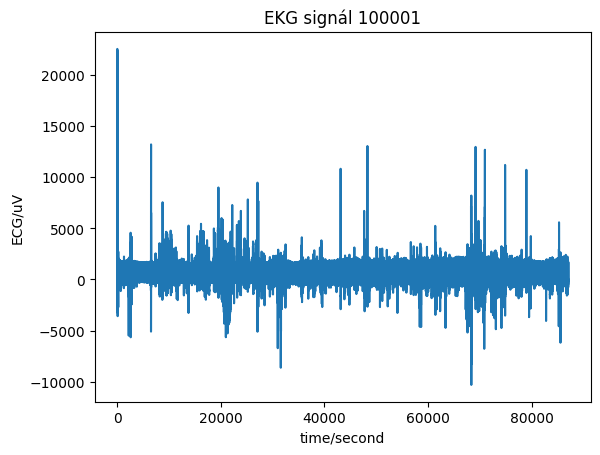

In [22]:
wfdb.plot_wfdb(record=ecg_100001, title="EKG signál 100001")

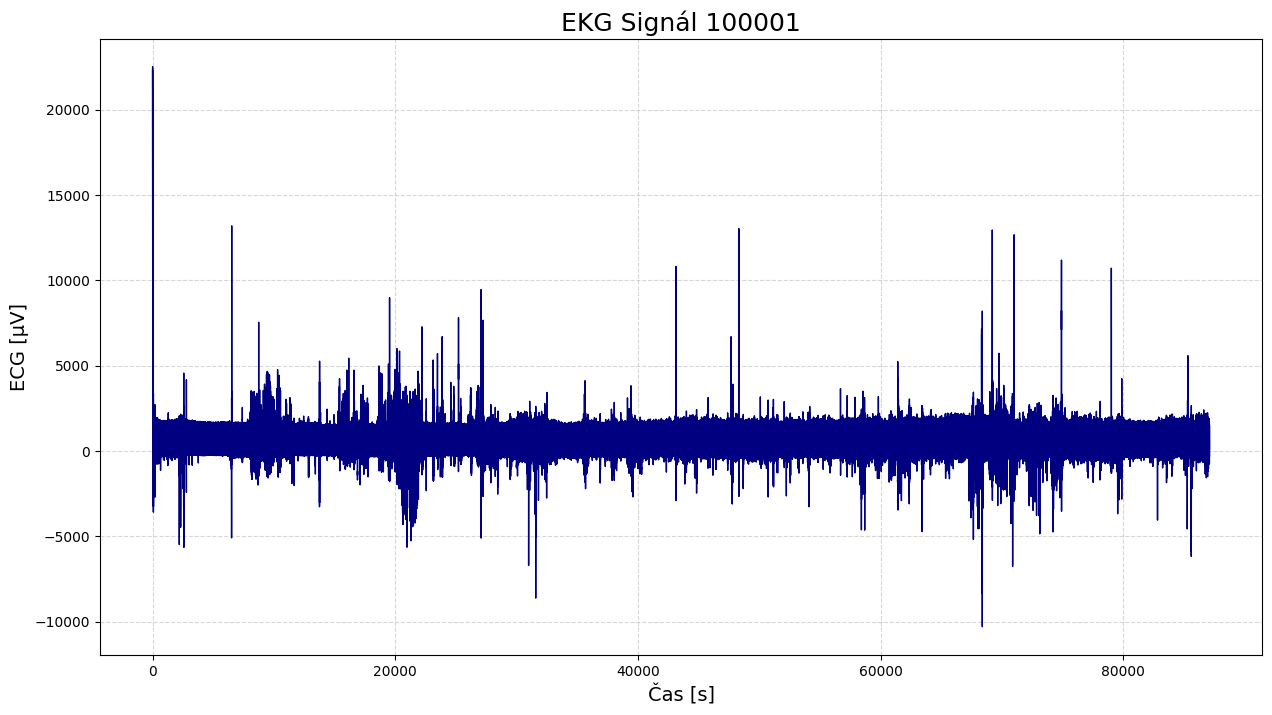

In [23]:
ecg_signal = ecg_100001.p_signal
sampling_frequency = 1000
time_axis = np.arange(len(ecg_signal)) / sampling_frequency

plt.figure(figsize=(15, 8))
plt.plot(time_axis, ecg_signal, color="navy", linewidth=1)
plt.title("EKG Signál 100001", fontsize=18)
plt.xlabel("Čas [s]", fontsize=14)
plt.ylabel("ECG [µV]", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()